In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "exoverstation," + \
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   pisa
   2   brescia
   3   bat
   4   rieti
   5   napoli
   6   caltanissetta
   7   vibo_valentia
   8   oristano
   9   lucca
   10   verbania
   11   trapani
   12   trieste
   13   cosenza
   14   pescara
   15   rovigo
   16   sassari
   17   la_spezia
   18   brindisi
   19   matera
   20   foggia
   21   pesaro
   22   genova
   23   vicenza
   24   messina
   25   prato
   26   pordenone
   27   salerno
   28   teramo
   29   enna
   30   forli
   31   cremona
   32   mantova
   33   agrigento
   34   milano
   35   lecce
   36   reggio_di_calabria
   37   parma
   38   massa
   39   vercelli
   40   macerata
   41   ferrara
   42   campobasso
   43   savona
   44   viterbo
   45   catania
   46   frosinone
   47   pavia
   48   udine
   49   grosseto
   50   belluno
   51   sondrio
   52   imperia
   53   pistoia
   54   siena
   55   carbonia
   56   novara
   57   como
   58   roma
   59   bari

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 pisa
2 brescia
3 bat
4 rieti
5 napoli
6 caltanissetta
7 vibo_valentia
8 oristano
9 lucca
10 verbania
11 trapani
12 trieste
13 cosenza
14 pescara
15 rovigo
16 sassari
17 la_spezia
18 brindisi
19 matera
20 foggia
21 pesaro
22 genova
23 vicenza
24 messina
25 prato
26 pordenone
27 salerno
28 teramo
29 enna
30 forli
31 cremona
32 mantova
33 agrigento
34 milano
35 lecce
36 reggio_di_calabria
37 parma
38 massa
39 vercelli
40 macerata
41 ferrara
42 campobasso
43 savona
44 viterbo
45 catania
46 frosinone
47 pavia
48 udine
49 grosseto
50 belluno
51 sondrio
52 imperia
53 pistoia
54 siena
55 novara
56 como
57 roma
58 bari
59 palermo
60 bergamo
61 terni
62 benevento
63 chieti
64 piacenza
65 catanzaro
66 alessandria
67 trento
68 ravenna
69 caserta
70 monza
71 firenze
72 bolzano
73 nuoro
74 ragusa
75 reggio_nell_emilia
76 varese
77 gorizia
78 ancona
79 latina
80 potenza
81 perugia
82 livorno
83 crotone
84 taranto
85 cuneo
86 verona
87 siracusa
88 rimini
89 venezia
90 l_aquila
91 treviso
92 padova
9

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.34727  0.02184 
    Test set average RMSE:  0.95914  0.10291 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34883
                       R2:  0.94432


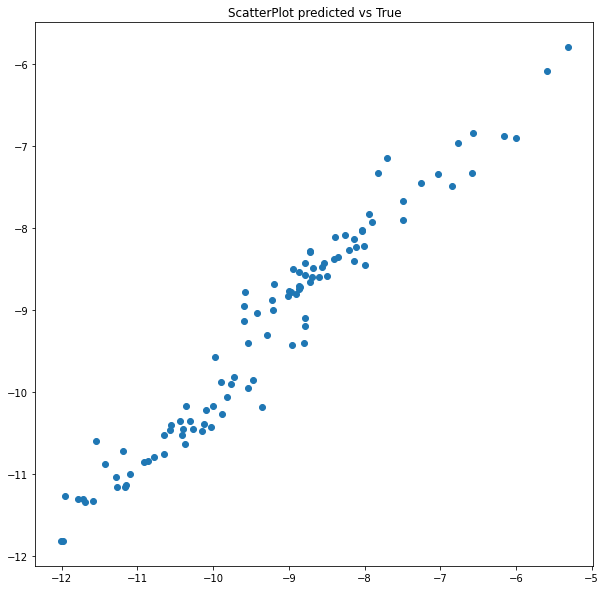

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02097
Feature:               commutersdensity, Score: 0.01547
Feature:                         depriv, Score: 0.02069
Feature:                            lat, Score: 0.65084
Feature:                 Ratio0200ver65, Score: 0.04617
Feature:           avg_wco_period1_2020, Score: 0.03826
Feature:          avg_wnh3_period1_2020, Score: 0.06919
Feature:           avg_wno_period1_2020, Score: 0.04413
Feature:           avg_wo3_period1_2020, Score: 0.03674
Feature:         avg_wpans_period1_2020, Score: 0.02654
Feature:          avg_wso2_period1_2020, Score: 0.03101


<Figure size 432x288 with 0 Axes>

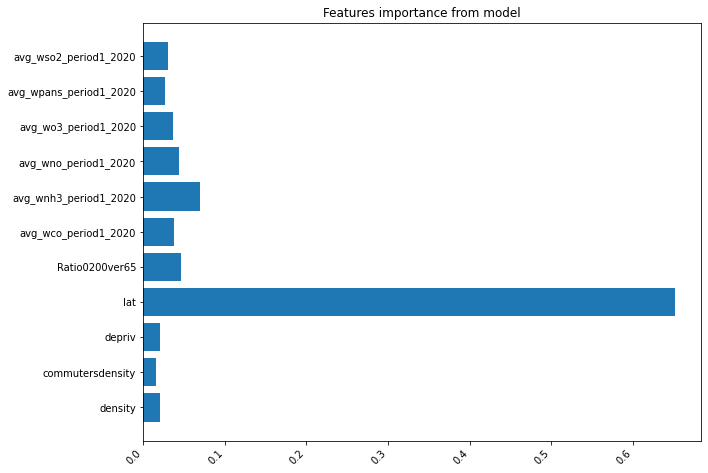

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.03960 +/- 0.00416
Feature:               commutersdensity, Score: 0.02795 +/- 0.00348
Feature:                         depriv, Score: 0.04009 +/- 0.00399
Feature:                            lat, Score: 2.70254 +/- 0.33890
Feature:                 Ratio0200ver65, Score: 0.09245 +/- 0.01455
Feature:           avg_wco_period1_2020, Score: 0.10294 +/- 0.01345
Feature:          avg_wnh3_period1_2020, Score: 0.18989 +/- 0.03124
Feature:           avg_wno_period1_2020, Score: 0.09708 +/- 0.01545
Feature:           avg_wo3_period1_2020, Score: 0.07664 +/- 0.00873
Feature:         avg_wpans_period1_2020, Score: 0.05591 +/- 0.00874
Feature:          avg_wso2_period1_2020, Score: 0.07383 +/- 0.01004


<Figure size 432x288 with 0 Axes>

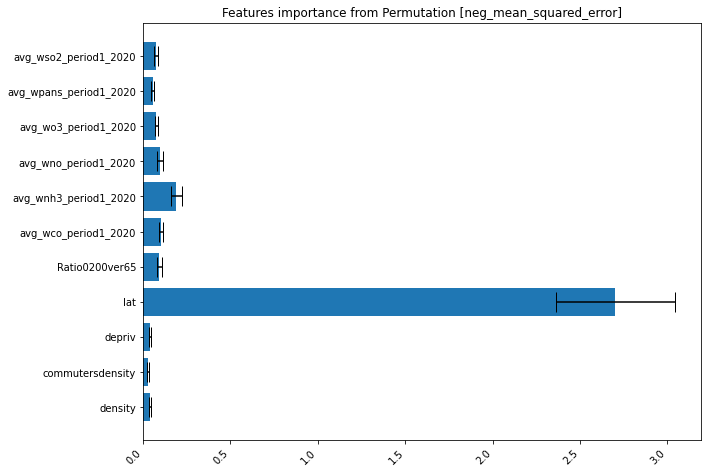

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.01812 +/- 0.00190
Feature:               commutersdensity, Score: 0.01279 +/- 0.00159
Feature:                         depriv, Score: 0.01834 +/- 0.00182
Feature:                            lat, Score: 1.23672 +/- 0.15508
Feature:                 Ratio0200ver65, Score: 0.04231 +/- 0.00666
Feature:           avg_wco_period1_2020, Score: 0.04711 +/- 0.00616
Feature:          avg_wnh3_period1_2020, Score: 0.08690 +/- 0.01430
Feature:           avg_wno_period1_2020, Score: 0.04443 +/- 0.00707
Feature:           avg_wo3_period1_2020, Score: 0.03507 +/- 0.00399
Feature:         avg_wpans_period1_2020, Score: 0.02558 +/- 0.00400
Feature:          avg_wso2_period1_2020, Score: 0.03379 +/- 0.00460


<Figure size 432x288 with 0 Axes>

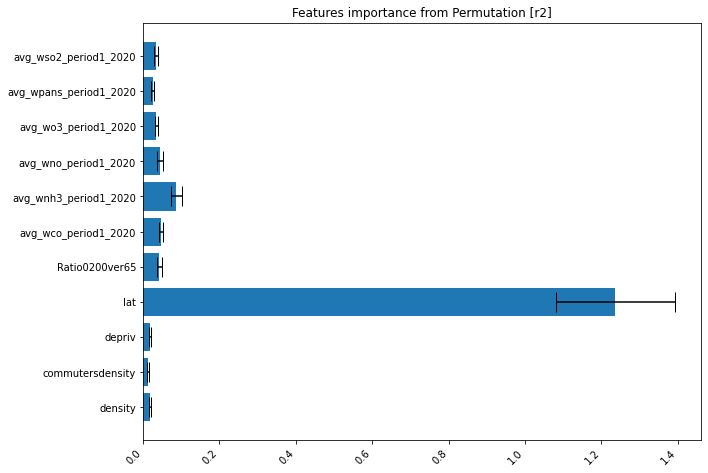

<Figure size 720x720 with 0 Axes>

((0.34726561635246694, 0.02183729147258393),
 (0.9591397052415654, 0.1029137676214336),
 0.34883114296386264,
 {'density': 0.011319020198272604,
  'commutersdensity': 0.007989487115468033,
  'depriv': 0.01145693846360636,
  'lat': 0.7723900815575296,
  'Ratio0200ver65': 0.02642265739728039,
  'avg_wco_period1_2020': 0.029420972346900918,
  'avg_wnh3_period1_2020': 0.05427123482636752,
  'avg_wno_period1_2020': 0.027745890459262408,
  'avg_wo3_period1_2020': 0.021903491578061072,
  'avg_wpans_period1_2020': 0.01597846606805104,
  'avg_wso2_period1_2020': 0.02110175998920002},
 {'density': 0.011319020198272627,
  'commutersdensity': 0.007989487115468052,
  'depriv': 0.011456938463606379,
  'lat': 0.7723900815575292,
  'Ratio0200ver65': 0.026422657397280398,
  'avg_wco_period1_2020': 0.02942097234690094,
  'avg_wnh3_period1_2020': 0.05427123482636755,
  'avg_wno_period1_2020': 0.027745890459262425,
  'avg_wo3_period1_2020': 0.02190349157806109,
  'avg_wpans_period1_2020': 0.01597846606805

<Figure size 432x288 with 0 Axes>

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures", showplot=True)

In [6]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.12168316630147477
2  of  1200 MSE:  0.11587567125004936
3  of  1200 MSE:  0.1786522641924183
4  of  1200 MSE:  0.205139807973986
5  of  1200 MSE:  0.39561313428401246
6  of  1200 MSE:  0.4836585470700437
7  of  1200 MSE:  0.5753886657072
8  of  1200 MSE:  0.6775766349122672
9  of  1200 MSE:  0.17152433891391053
10  of  1200 MSE:  0.19105889246321547
11  of  1200 MSE:  0.1956555678015562
12  of  1200 MSE:  0.23517750677712407
13  of  1200 MSE:  0.39561313428401246
14  of  1200 MSE:  0.4836585470700437
15  of  1200 MSE:  0.5753886657072
16  of  1200 MSE:  0.6775766349122672
17  of  1200 MSE:  0.26992144121496003
18  of  1200 MSE:  0.3304949221209699
19  of  1200 MSE:  0.29718631908186943
20  of  1200 MSE:  0.3586514662074355
21  of  1200 MSE:  0.39561313428401246
22  of  1200 MSE:  0.4836585470700437
23  of  1200 MSE:  0.5753886657072
24  of  1200 MSE:  0.6775766349122672
25  of  1200 MSE:  0.3723623280876994
26  of  1200 MSE:  0.4361843975126566
27  of  1200 MSE:  0.

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500,
 'random_state': 1}
Training set average RMSE:  0.34154  0.02168 
    Test set average RMSE:  0.91467  0.10251 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.32995
                       R2:  0.95018


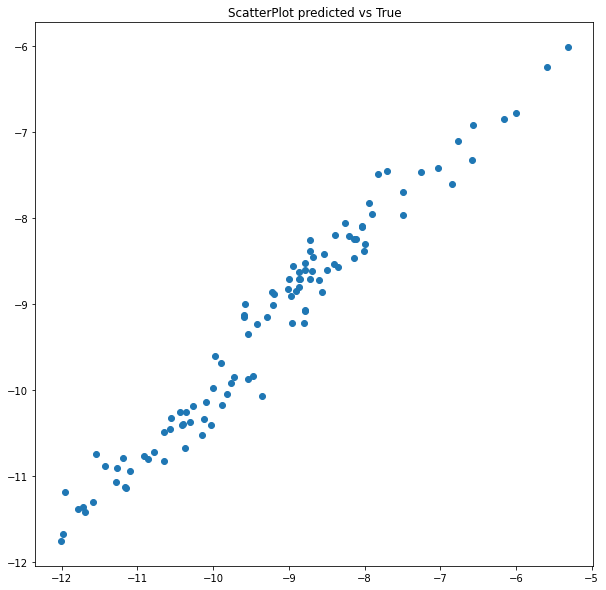

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03112
Feature:               commutersdensity, Score: 0.16022
Feature:                         depriv, Score: 0.07703
Feature:                            lat, Score: 0.24796
Feature:                 Ratio0200ver65, Score: 0.05002
Feature:           avg_wco_period1_2020, Score: 0.11227
Feature:          avg_wnh3_period1_2020, Score: 0.07393
Feature:           avg_wno_period1_2020, Score: 0.10139
Feature:           avg_wo3_period1_2020, Score: 0.07292
Feature:         avg_wpans_period1_2020, Score: 0.03329
Feature:          avg_wso2_period1_2020, Score: 0.03984


<Figure size 432x288 with 0 Axes>

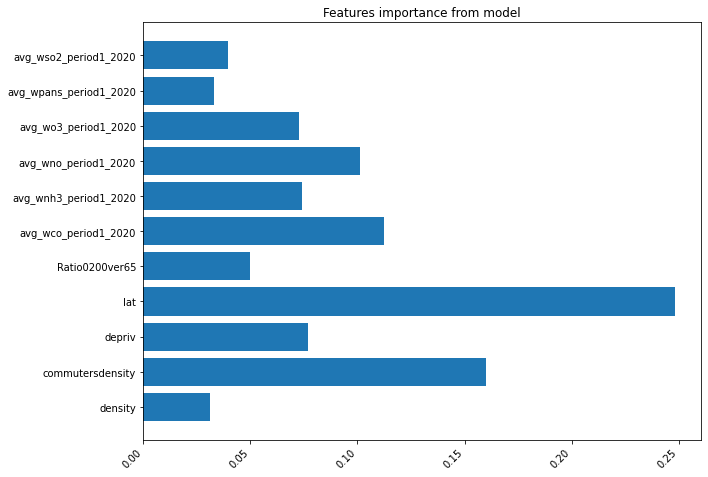

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.03993 +/- 0.00407
Feature:               commutersdensity, Score: 0.02291 +/- 0.00324
Feature:                         depriv, Score: 0.04280 +/- 0.00330
Feature:                            lat, Score: 2.80340 +/- 0.34631
Feature:                 Ratio0200ver65, Score: 0.09943 +/- 0.01563
Feature:           avg_wco_period1_2020, Score: 0.07742 +/- 0.01098
Feature:          avg_wnh3_period1_2020, Score: 0.14078 +/- 0.01937
Feature:           avg_wno_period1_2020, Score: 0.13147 +/- 0.02061
Feature:           avg_wo3_period1_2020, Score: 0.09370 +/- 0.00949
Feature:         avg_wpans_period1_2020, Score: 0.05365 +/- 0.00811
Feature:          avg_wso2_period1_2020, Score: 0.07192 +/- 0.00812


<Figure size 432x288 with 0 Axes>

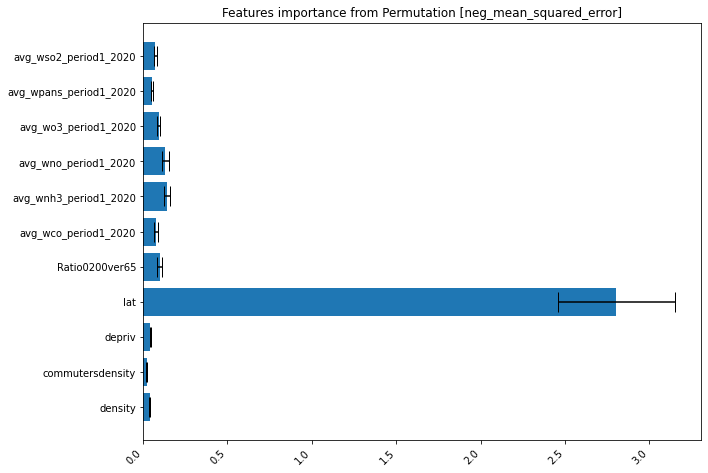

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.01827 +/- 0.00186
Feature:               commutersdensity, Score: 0.01048 +/- 0.00148
Feature:                         depriv, Score: 0.01959 +/- 0.00151
Feature:                            lat, Score: 1.28287 +/- 0.15848
Feature:                 Ratio0200ver65, Score: 0.04550 +/- 0.00715
Feature:           avg_wco_period1_2020, Score: 0.03543 +/- 0.00502
Feature:          avg_wnh3_period1_2020, Score: 0.06442 +/- 0.00886
Feature:           avg_wno_period1_2020, Score: 0.06016 +/- 0.00943
Feature:           avg_wo3_period1_2020, Score: 0.04288 +/- 0.00434
Feature:         avg_wpans_period1_2020, Score: 0.02455 +/- 0.00371
Feature:          avg_wso2_period1_2020, Score: 0.03291 +/- 0.00372


<Figure size 432x288 with 0 Axes>

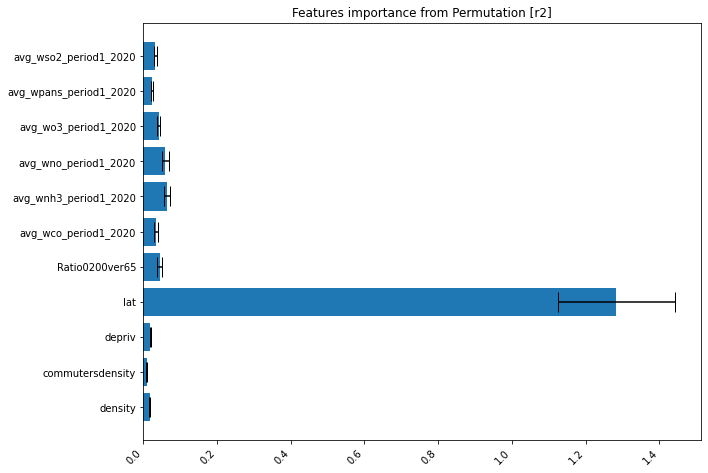

<Figure size 720x720 with 0 Axes>

((0.3415379458095667, 0.021675085196347726),
 (0.9146733821062647, 0.10250999078859152),
 0.32995199688799587,
 {'density': 0.01116290612602854,
  'commutersdensity': 0.0064036196659961395,
  'depriv': 0.011964549848296827,
  'lat': 0.7836380505506423,
  'Ratio0200ver65': 0.02779395023523383,
  'avg_wco_period1_2020': 0.021641649962539776,
  'avg_wnh3_period1_2020': 0.03935302402303725,
  'avg_wno_period1_2020': 0.036749319794982804,
  'avg_wo3_period1_2020': 0.0261933379423797,
  'avg_wpans_period1_2020': 0.014996304862622474,
  'avg_wso2_period1_2020': 0.02010328698824043},
 {'density': 0.011162906126028573,
  'commutersdensity': 0.006403619665996172,
  'depriv': 0.01196454984829686,
  'lat': 0.783638050550642,
  'Ratio0200ver65': 0.02779395023523386,
  'avg_wco_period1_2020': 0.021641649962539804,
  'avg_wnh3_period1_2020': 0.03935302402303727,
  'avg_wno_period1_2020': 0.036749319794982825,
  'avg_wo3_period1_2020': 0.02619333794237973,
  'avg_wpans_period1_2020': 0.014996304862622

<Figure size 432x288 with 0 Axes>

In [7]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.38304  0.02621 
    Test set average RMSE:  1.01369  0.09488 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.37357
                       R2:  0.93614


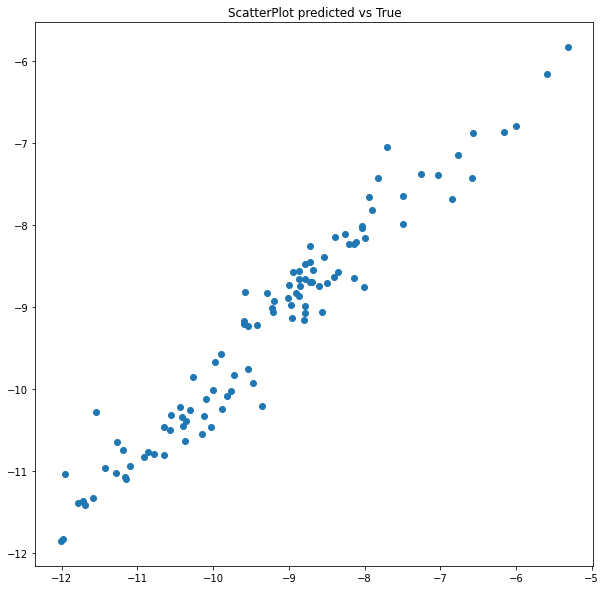

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02975
Feature:               commutersdensity, Score: 0.47760
Feature:                         depriv, Score: 0.03456
Feature:                 Ratio0200ver65, Score: 0.08065
Feature:           avg_wco_period1_2020, Score: 0.07119
Feature:          avg_wnh3_period1_2020, Score: 0.08136
Feature:           avg_wno_period1_2020, Score: 0.10316
Feature:           avg_wo3_period1_2020, Score: 0.04503
Feature:         avg_wpans_period1_2020, Score: 0.03572
Feature:          avg_wso2_period1_2020, Score: 0.04097


<Figure size 432x288 with 0 Axes>

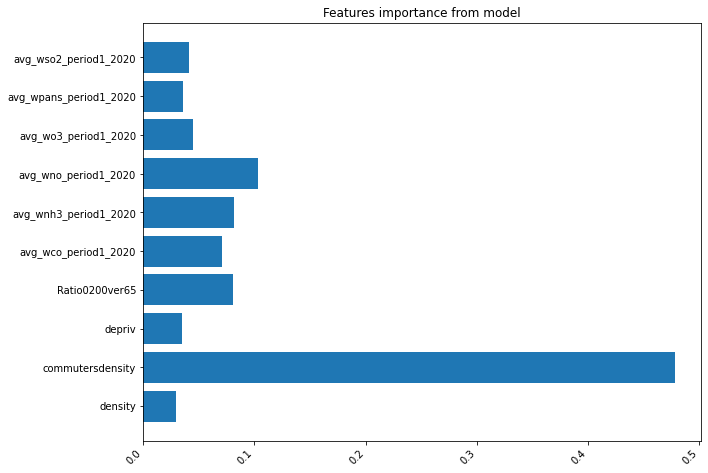

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.03859 +/- 0.00434
Feature:               commutersdensity, Score: 1.51445 +/- 0.23572
Feature:                         depriv, Score: 0.05696 +/- 0.00660
Feature:                 Ratio0200ver65, Score: 0.17342 +/- 0.01945
Feature:           avg_wco_period1_2020, Score: 0.16247 +/- 0.01989
Feature:          avg_wnh3_period1_2020, Score: 0.19258 +/- 0.03098
Feature:           avg_wno_period1_2020, Score: 0.24906 +/- 0.03315
Feature:           avg_wo3_period1_2020, Score: 0.11621 +/- 0.01027
Feature:         avg_wpans_period1_2020, Score: 0.08981 +/- 0.01645
Feature:          avg_wso2_period1_2020, Score: 0.06543 +/- 0.00855


<Figure size 432x288 with 0 Axes>

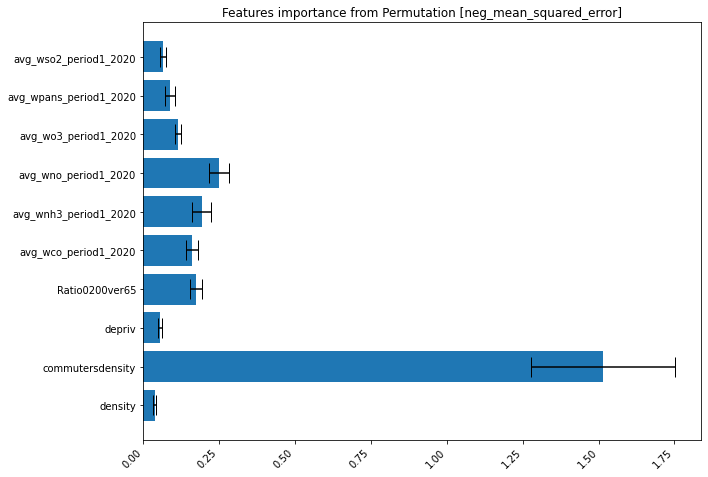

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.01766 +/- 0.00199
Feature:               commutersdensity, Score: 0.69303 +/- 0.10787
Feature:                         depriv, Score: 0.02607 +/- 0.00302
Feature:                 Ratio0200ver65, Score: 0.07936 +/- 0.00890
Feature:           avg_wco_period1_2020, Score: 0.07435 +/- 0.00910
Feature:          avg_wnh3_period1_2020, Score: 0.08813 +/- 0.01418
Feature:           avg_wno_period1_2020, Score: 0.11397 +/- 0.01517
Feature:           avg_wo3_period1_2020, Score: 0.05318 +/- 0.00470
Feature:         avg_wpans_period1_2020, Score: 0.04110 +/- 0.00753
Feature:          avg_wso2_period1_2020, Score: 0.02994 +/- 0.00391


<Figure size 432x288 with 0 Axes>

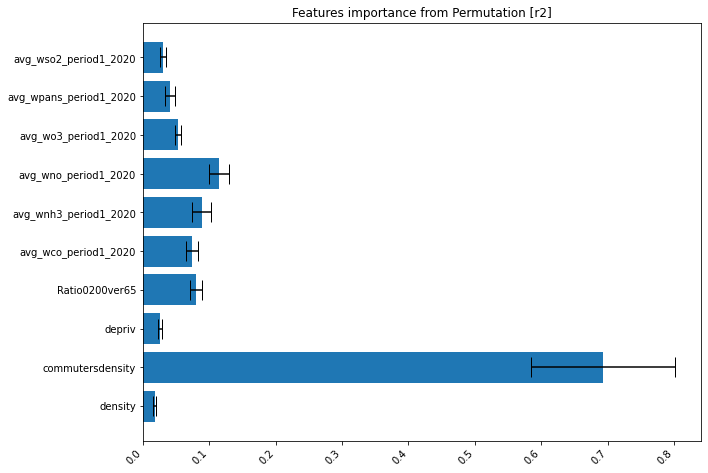

<Figure size 720x720 with 0 Axes>

((0.3830396265481679, 0.02621264692106239),
 (1.0136930773157184, 0.09488309147362932),
 0.3735734710137013,
 {'density': 0.014511860840132661,
  'commutersdensity': 0.5695605778825288,
  'depriv': 0.021423042607587494,
  'Ratio0200ver65': 0.06522139168040281,
  'avg_wco_period1_2020': 0.0611021087793755,
  'avg_wnh3_period1_2020': 0.0724270681701154,
  'avg_wno_period1_2020': 0.0936687316447316,
  'avg_wo3_period1_2020': 0.043703847727553036,
  'avg_wpans_period1_2020': 0.03377598677939937,
  'avg_wso2_period1_2020': 0.02460538388817354},
 {'density': 0.014511860840132652,
  'commutersdensity': 0.5695605778825287,
  'depriv': 0.02142304260758749,
  'Ratio0200ver65': 0.06522139168040278,
  'avg_wco_period1_2020': 0.06110210877937549,
  'avg_wnh3_period1_2020': 0.07242706817011538,
  'avg_wno_period1_2020': 0.09366873164473159,
  'avg_wo3_period1_2020': 0.043703847727553015,
  'avg_wpans_period1_2020': 0.033775986779399365,
  'avg_wso2_period1_2020': 0.024605383888173526})

<Figure size 432x288 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat", pout=sys.stdout, showplot=True)

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.13955713824522473
2  of  1200 MSE:  0.13686195460770917
3  of  1200 MSE:  0.20467472627184588
4  of  1200 MSE:  0.24829200436459706
5  of  1200 MSE:  0.4780532268959219
6  of  1200 MSE:  0.5543419613499428
7  of  1200 MSE:  0.7129753318537563
8  of  1200 MSE:  0.7677083995302751
9  of  1200 MSE:  0.1914399886363654
10  of  1200 MSE:  0.22133416455116922
11  of  1200 MSE:  0.22618942710867748
12  of  1200 MSE:  0.27563558558315304
13  of  1200 MSE:  0.4780532268959219
14  of  1200 MSE:  0.5543419613499428
15  of  1200 MSE:  0.7129753318537563
16  of  1200 MSE:  0.7677083995302751
17  of  1200 MSE:  0.309332408740205
18  of  1200 MSE:  0.37762680708486257
19  of  1200 MSE:  0.34246542008150954
20  of  1200 MSE:  0.406148697459526
21  of  1200 MSE:  0.4780532268959219
22  of  1200 MSE:  0.5543419613499428
23  of  1200 MSE:  0.7129753318537563
24  of  1200 MSE:  0.7677083995302751
25  of  1200 MSE:  0.44203972458755697
26  of  1200 MSE:  0.4888205684277324
27  of  1200 

Training set average RMSE:  0.36187  0.02308 
    Test set average RMSE:  1.00858  0.09499 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35199
                       R2:  0.94330


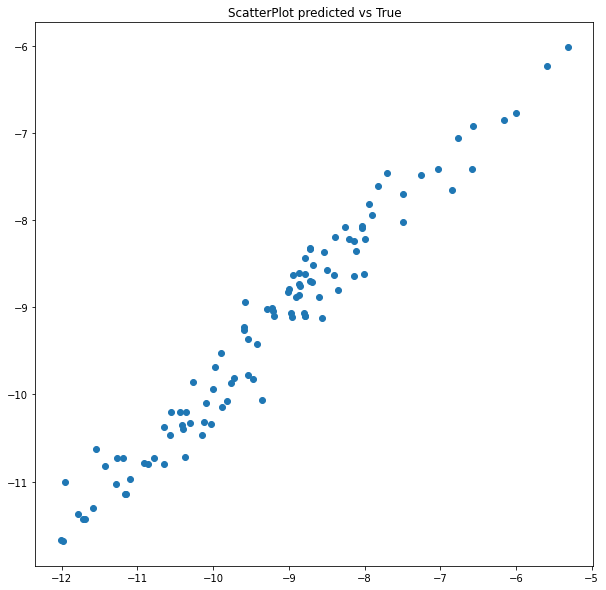

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03813
Feature:               commutersdensity, Score: 0.23193
Feature:                         depriv, Score: 0.10807
Feature:                 Ratio0200ver65, Score: 0.06598
Feature:           avg_wco_period1_2020, Score: 0.12608
Feature:          avg_wnh3_period1_2020, Score: 0.09195
Feature:           avg_wno_period1_2020, Score: 0.15568
Feature:           avg_wo3_period1_2020, Score: 0.08656
Feature:         avg_wpans_period1_2020, Score: 0.03986
Feature:          avg_wso2_period1_2020, Score: 0.05576


<Figure size 432x288 with 0 Axes>

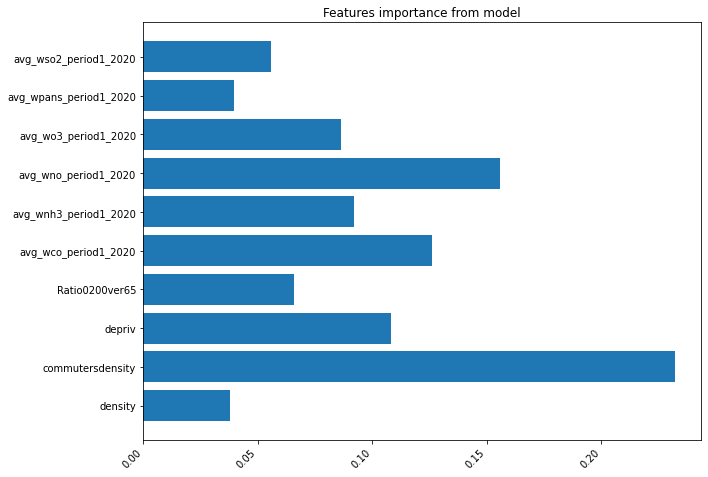

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04845 +/- 0.00513
Feature:               commutersdensity, Score: 1.73267 +/- 0.29174
Feature:                         depriv, Score: 0.05992 +/- 0.00705
Feature:                 Ratio0200ver65, Score: 0.19706 +/- 0.02193
Feature:           avg_wco_period1_2020, Score: 0.17020 +/- 0.02084
Feature:          avg_wnh3_period1_2020, Score: 0.21376 +/- 0.03224
Feature:           avg_wno_period1_2020, Score: 0.16552 +/- 0.02425
Feature:           avg_wo3_period1_2020, Score: 0.10671 +/- 0.00896
Feature:         avg_wpans_period1_2020, Score: 0.07902 +/- 0.01324
Feature:          avg_wso2_period1_2020, Score: 0.07994 +/- 0.01184


<Figure size 432x288 with 0 Axes>

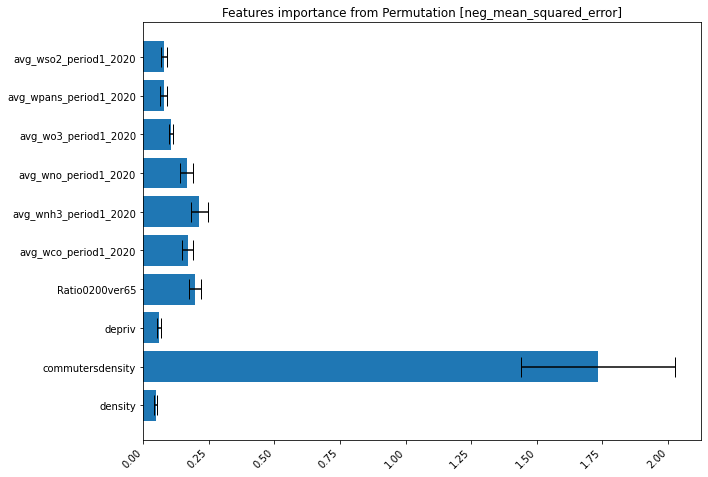

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02217 +/- 0.00235
Feature:               commutersdensity, Score: 0.79289 +/- 0.13351
Feature:                         depriv, Score: 0.02742 +/- 0.00323
Feature:                 Ratio0200ver65, Score: 0.09018 +/- 0.01003
Feature:           avg_wco_period1_2020, Score: 0.07789 +/- 0.00954
Feature:          avg_wnh3_period1_2020, Score: 0.09782 +/- 0.01475
Feature:           avg_wno_period1_2020, Score: 0.07574 +/- 0.01110
Feature:           avg_wo3_period1_2020, Score: 0.04883 +/- 0.00410
Feature:         avg_wpans_period1_2020, Score: 0.03616 +/- 0.00606
Feature:          avg_wso2_period1_2020, Score: 0.03658 +/- 0.00542


<Figure size 432x288 with 0 Axes>

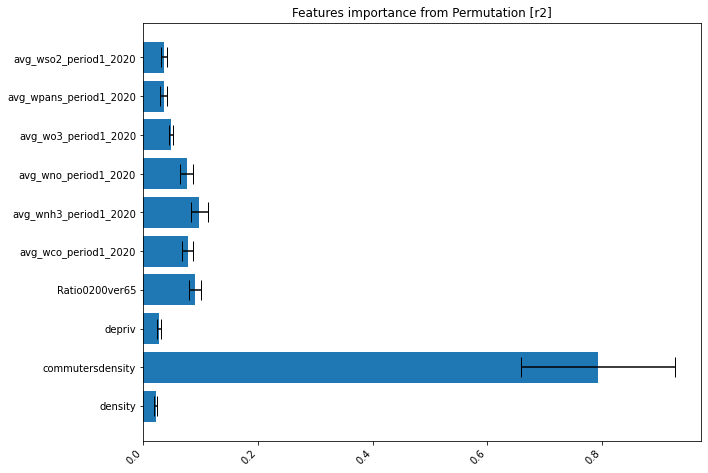

<Figure size 720x720 with 0 Axes>

((0.36187474407194203, 0.023078137901755832),
 (1.0085810323427071, 0.09498957839705811),
 0.35198783887089813,
 {'density': 0.016978998556749825,
  'commutersdensity': 0.6072609025547698,
  'depriv': 0.021001060250407665,
  'Ratio0200ver65': 0.06906494006526555,
  'avg_wco_period1_2020': 0.059652899735756396,
  'avg_wnh3_period1_2020': 0.07491945504432108,
  'avg_wno_period1_2020': 0.05801001735714576,
  'avg_wo3_period1_2020': 0.03740002959022502,
  'avg_wpans_period1_2020': 0.02769325141374449,
  'avg_wso2_period1_2020': 0.028018445431614223},
 {'density': 0.016978998556749825,
  'commutersdensity': 0.6072609025547698,
  'depriv': 0.021001060250407665,
  'Ratio0200ver65': 0.06906494006526555,
  'avg_wco_period1_2020': 0.0596528997357564,
  'avg_wnh3_period1_2020': 0.0749194550443211,
  'avg_wno_period1_2020': 0.05801001735714575,
  'avg_wo3_period1_2020': 0.03740002959022502,
  'avg_wpans_period1_2020': 0.02769325141374449,
  'avg_wso2_period1_2020': 0.028018445431614226})

<Figure size 432x288 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.40402  0.02880 
    Test set average RMSE:  1.07196  0.11680 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.38589
                       R2:  0.93186


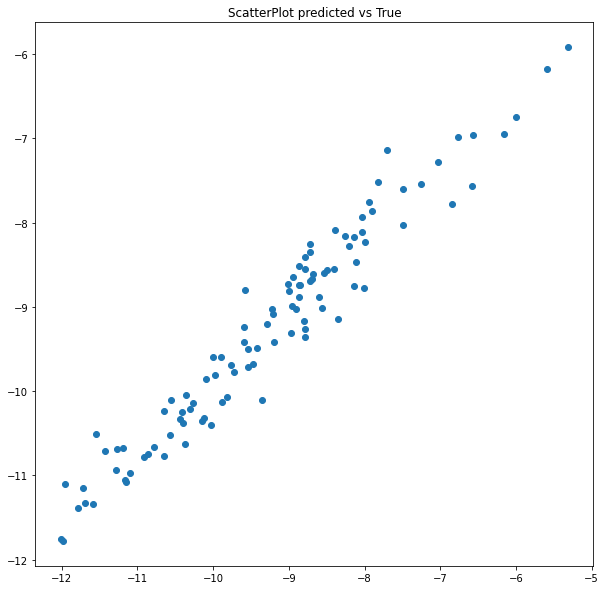

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02813
Feature:                         depriv, Score: 0.17630
Feature:                 Ratio0200ver65, Score: 0.08141
Feature:           avg_wco_period1_2020, Score: 0.12542
Feature:          avg_wnh3_period1_2020, Score: 0.11176
Feature:           avg_wno_period1_2020, Score: 0.30393
Feature:           avg_wo3_period1_2020, Score: 0.06335
Feature:         avg_wpans_period1_2020, Score: 0.05794
Feature:          avg_wso2_period1_2020, Score: 0.05175


<Figure size 432x288 with 0 Axes>

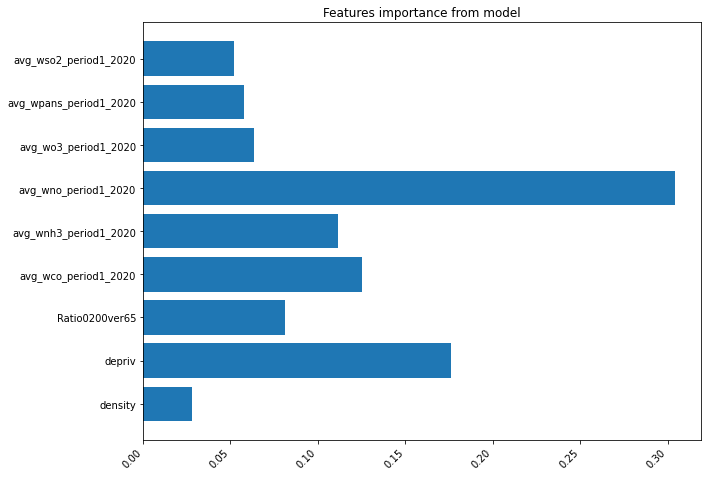

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05696 +/- 0.00765
Feature:                         depriv, Score: 0.49408 +/- 0.06955
Feature:                 Ratio0200ver65, Score: 0.13186 +/- 0.01212
Feature:           avg_wco_period1_2020, Score: 0.23213 +/- 0.03137
Feature:          avg_wnh3_period1_2020, Score: 0.28269 +/- 0.04263
Feature:           avg_wno_period1_2020, Score: 0.65087 +/- 0.08672
Feature:           avg_wo3_period1_2020, Score: 0.14962 +/- 0.01492
Feature:         avg_wpans_period1_2020, Score: 0.15109 +/- 0.02161
Feature:          avg_wso2_period1_2020, Score: 0.09422 +/- 0.01292


<Figure size 432x288 with 0 Axes>

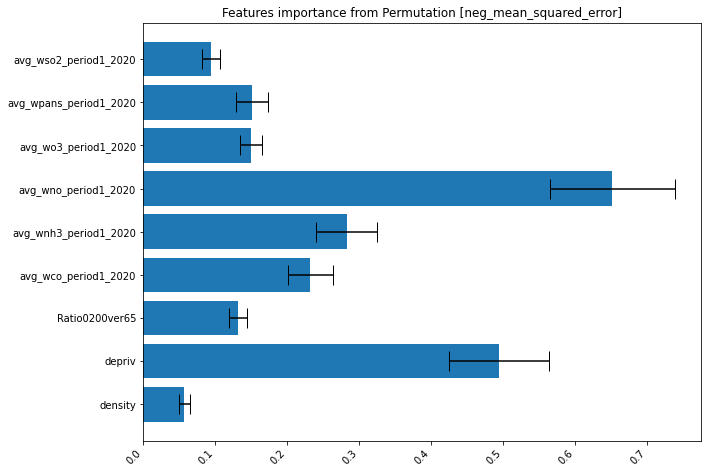

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02606 +/- 0.00350
Feature:                         depriv, Score: 0.22610 +/- 0.03183
Feature:                 Ratio0200ver65, Score: 0.06034 +/- 0.00555
Feature:           avg_wco_period1_2020, Score: 0.10623 +/- 0.01435
Feature:          avg_wnh3_period1_2020, Score: 0.12936 +/- 0.01951
Feature:           avg_wno_period1_2020, Score: 0.29785 +/- 0.03969
Feature:           avg_wo3_period1_2020, Score: 0.06847 +/- 0.00683
Feature:         avg_wpans_period1_2020, Score: 0.06914 +/- 0.00989
Feature:          avg_wso2_period1_2020, Score: 0.04311 +/- 0.00591


<Figure size 432x288 with 0 Axes>

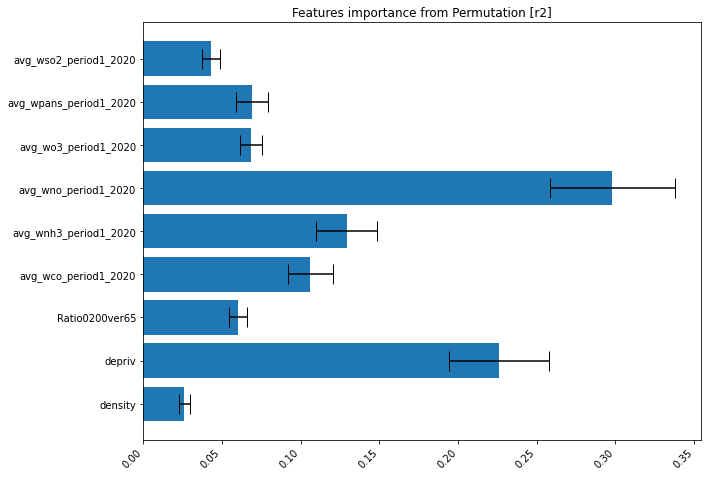

<Figure size 720x720 with 0 Axes>

((0.4040232186717266, 0.028796661326576378),
 (1.0719622094426322, 0.11680100642476228),
 0.38588607084274174,
 {'density': 0.025387313832656588,
  'depriv': 0.22022551782520952,
  'Ratio0200ver65': 0.058775428894080044,
  'avg_wco_period1_2020': 0.10346789650577648,
  'avg_wnh3_period1_2020': 0.12600416733812694,
  'avg_wno_period1_2020': 0.29010903785258,
  'avg_wo3_period1_2020': 0.06669119385304473,
  'avg_wpans_period1_2020': 0.06734467650093352,
  'avg_wso2_period1_2020': 0.04199476739759204},
 {'density': 0.025387313832656556,
  'depriv': 0.22022551782520966,
  'Ratio0200ver65': 0.058775428894080016,
  'avg_wco_period1_2020': 0.10346789650577652,
  'avg_wnh3_period1_2020': 0.12600416733812697,
  'avg_wno_period1_2020': 0.29010903785258013,
  'avg_wo3_period1_2020': 0.06669119385304471,
  'avg_wpans_period1_2020': 0.06734467650093351,
  'avg_wso2_period1_2020': 0.041994767397591996})

<Figure size 432x288 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocommut", pout=sys.stdout, showplot=True)

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.1489080596704495
2  of  1200 MSE:  0.14012228116285325
3  of  1200 MSE:  0.2194715672459182
4  of  1200 MSE:  0.25645254047499944
5  of  1200 MSE:  0.5309964603190982
6  of  1200 MSE:  0.6098098489946101
7  of  1200 MSE:  0.8175265595793064
8  of  1200 MSE:  0.8628934016930775
9  of  1200 MSE:  0.2074927696177169
10  of  1200 MSE:  0.21639752296909626
11  of  1200 MSE:  0.24149259474213064
12  of  1200 MSE:  0.2868529736299904
13  of  1200 MSE:  0.5309964603190982
14  of  1200 MSE:  0.6098098489946101
15  of  1200 MSE:  0.8175265595793064
16  of  1200 MSE:  0.8628934016930775
17  of  1200 MSE:  0.34347418191296764
18  of  1200 MSE:  0.37615441624186813
19  of  1200 MSE:  0.370601573963351
20  of  1200 MSE:  0.41979423889768525
21  of  1200 MSE:  0.5309964603190982
22  of  1200 MSE:  0.6098098489946101
23  of  1200 MSE:  0.8175265595793064
24  of  1200 MSE:  0.8628934016930775
25  of  1200 MSE:  0.48799740893221843
26  of  1200 MSE:  0.544329235268398
27  of  1200 MS

Training set average RMSE:  0.38050  0.02222 
    Test set average RMSE:  1.05172  0.08758 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36617
                       R2:  0.93864


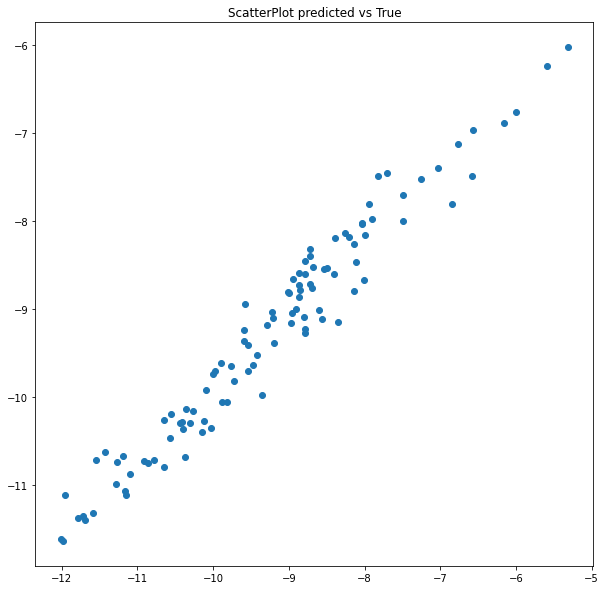

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.04588
Feature:                         depriv, Score: 0.16257
Feature:                 Ratio0200ver65, Score: 0.07538
Feature:           avg_wco_period1_2020, Score: 0.17208
Feature:          avg_wnh3_period1_2020, Score: 0.12523
Feature:           avg_wno_period1_2020, Score: 0.18950
Feature:           avg_wo3_period1_2020, Score: 0.11056
Feature:         avg_wpans_period1_2020, Score: 0.05557
Feature:          avg_wso2_period1_2020, Score: 0.06324


<Figure size 432x288 with 0 Axes>

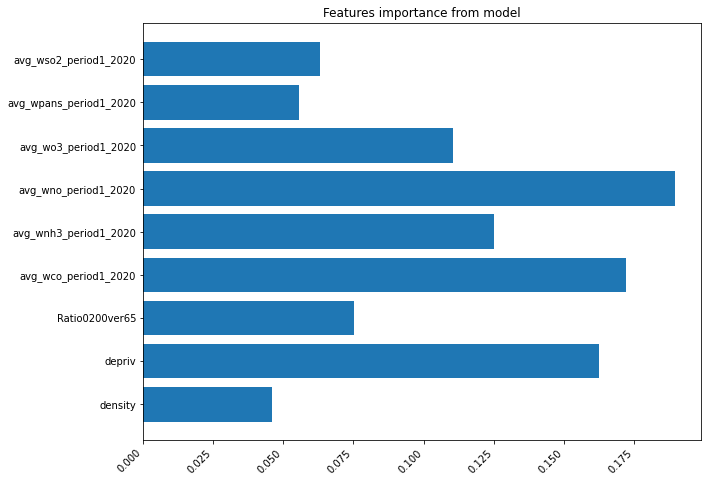

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04215 +/- 0.00542
Feature:                         depriv, Score: 0.47350 +/- 0.07329
Feature:                 Ratio0200ver65, Score: 0.14987 +/- 0.01496
Feature:           avg_wco_period1_2020, Score: 0.28408 +/- 0.03641
Feature:          avg_wnh3_period1_2020, Score: 0.25770 +/- 0.04135
Feature:           avg_wno_period1_2020, Score: 0.54688 +/- 0.07310
Feature:           avg_wo3_period1_2020, Score: 0.14279 +/- 0.01183
Feature:         avg_wpans_period1_2020, Score: 0.13499 +/- 0.01969
Feature:          avg_wso2_period1_2020, Score: 0.12912 +/- 0.01612


<Figure size 432x288 with 0 Axes>

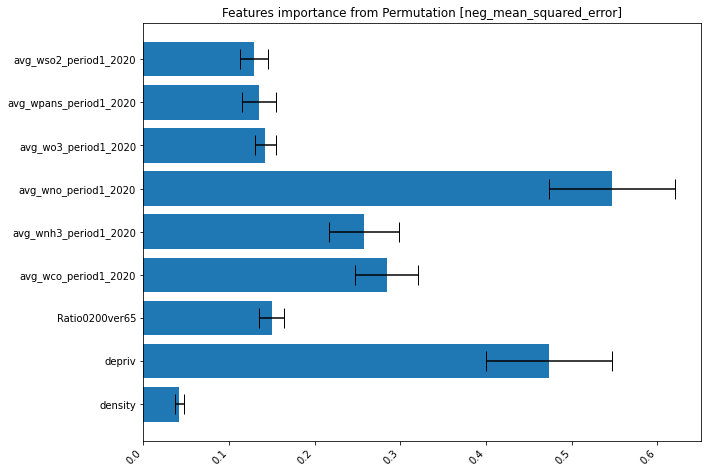

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.01929 +/- 0.00248
Feature:                         depriv, Score: 0.21668 +/- 0.03354
Feature:                 Ratio0200ver65, Score: 0.06858 +/- 0.00684
Feature:           avg_wco_period1_2020, Score: 0.13000 +/- 0.01666
Feature:          avg_wnh3_period1_2020, Score: 0.11793 +/- 0.01892
Feature:           avg_wno_period1_2020, Score: 0.25026 +/- 0.03345
Feature:           avg_wo3_period1_2020, Score: 0.06534 +/- 0.00541
Feature:         avg_wpans_period1_2020, Score: 0.06177 +/- 0.00901
Feature:          avg_wso2_period1_2020, Score: 0.05909 +/- 0.00737


<Figure size 432x288 with 0 Axes>

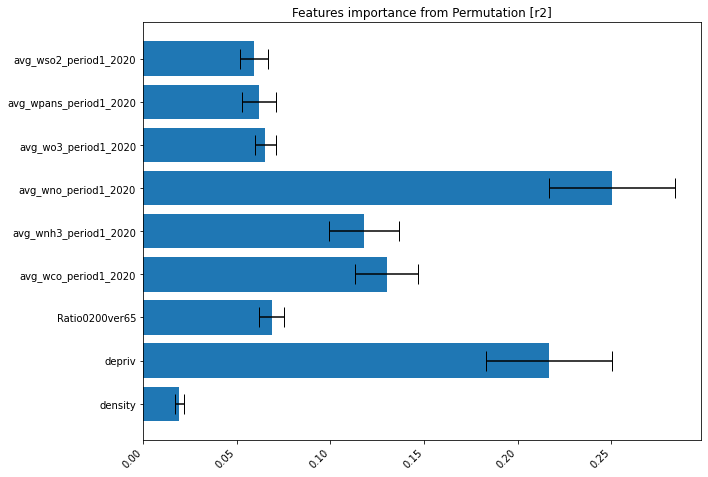

<Figure size 720x720 with 0 Axes>

((0.3804968804141091, 0.02221618610115719),
 (1.0517162085952798, 0.08758180061639381),
 0.36616904585018933,
 {'density': 0.01950223724289087,
  'depriv': 0.2191038883339463,
  'Ratio0200ver65': 0.06934838913850426,
  'avg_wco_period1_2020': 0.1314549797509869,
  'avg_wnh3_period1_2020': 0.11924689924392069,
  'avg_wno_period1_2020': 0.253058266611708,
  'avg_wo3_period1_2020': 0.06607498109811719,
  'avg_wpans_period1_2020': 0.062462584244856845,
  'avg_wso2_period1_2020': 0.05974777433506918},
 {'density': 0.01950223724289087,
  'depriv': 0.21910388833394626,
  'Ratio0200ver65': 0.06934838913850426,
  'avg_wco_period1_2020': 0.13145497975098688,
  'avg_wnh3_period1_2020': 0.11924689924392066,
  'avg_wno_period1_2020': 0.2530582666117079,
  'avg_wo3_period1_2020': 0.06607498109811719,
  'avg_wpans_period1_2020': 0.06246258424485683,
  'avg_wso2_period1_2020': 0.05974777433506915})

<Figure size 432x288 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocommut_opt", showplot=True, optimisedparams=bestf)